# AIRL Evalutation on Classification Task and Quality of Learned Policy

In [1]:
import ast

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy

import graph_reinforcement_learning_using_blockchain_data as grl

2025-05-15 14:33:56.962 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


## Setup

In [2]:
file_paths = [
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_1_train.csv",
    grl.PROCESSED_DATA_DIR / f"AIRL" / "airl_1_test.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_val.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_0_train.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_0_test.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings_dgi_128.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings_pre_trained_128.csv",
]

In [3]:
eth_data_dict = grl.load_dataframes(file_paths[:5])
embeddings_dict = grl.load_dataframes(file_paths[5:])

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/graph_reinforcement_learning_using_blockchain_data/utils.py:121: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes_dict[key] = pd.read_csv(path)


In [4]:
for k, df in embeddings_dict.items():
    df["embeddings"] = df["embeddings"].apply(
        lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
    )
    embeddings_dict[k] = df

In [5]:
data_dict = {}
for k, emb in embeddings_dict.items():
    data_dict.setdefault(k, {})
    for key, df in eth_data_dict.items():
        data_dict[k][key] = pd.merge(
            df, emb, how="inner", left_on="transaction_hash", right_on="transactionHash"
        )

In [6]:
trajectories = {}
for k, dicti in data_dict.items():
    trajectories[k] = grl.extract_trajectories(dicti)

In [7]:
venvs = {}
for k, df_dict in data_dict.items():
    grl.register_envs(df_dict)
    venvs[k] = grl.make_venvs(df_dict)

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv_airl_1_train_v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/TransactionGraphEnv_airl_1_test_v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment gymnasium_env/Transa

In [8]:
def download_reward_net(url: str) -> torch.nn.Module:
    url = mlflow.artifacts.download_artifacts(artifact_uri=url)
    reward_net = torch.load(url, weights_only=False)
    reward_net.eval()
    return reward_net


def download_learner(url: str):
    url = mlflow.artifacts.download_artifacts(artifact_uri=url)
    learner_trained = PPO.load(url, weights_only=False)
    return learner_trained

In [9]:
def calcualte_calibrated_rewards(
    reward_net0, reward_net1, alpha0, alpha1, beta0, beta1, test_trajectories
):
    states, obs, next_states, dones = (
        test_trajectories.obs,
        test_trajectories.acts,
        test_trajectories.next_obs,
        test_trajectories.dones,
    )
    with torch.no_grad():
        # For reward_net0
        rewards0 = reward_net0.predict(states, obs, next_states, dones)
        calibrated_rewards0 = alpha0 * rewards0 + beta0
        print("Reward network 0: ", calibrated_rewards0.mean())

        # For reward_net1
        rewards1 = reward_net1.predict(states, obs, next_states, dones)
        calibrated_rewards1 = alpha1 * rewards1 + beta1
        print("Reward network 1: ", calibrated_rewards1.mean())

    return calibrated_rewards0, calibrated_rewards1

In [10]:
def calc_stats(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [11]:
def calc_overall_metrics(rewards0_traj_0, rewards1_traj_0, rewards1_traj0, rewards1_traj1):
    predictions_trajectories_0 = [
        0 if r0 > r1 else 1 for r0, r1 in zip(rewards0_traj_0, rewards1_traj_0)
    ]
    true_labels_0 = [0] * len(predictions_trajectories_0)

    predictions_trajectories_1 = [
        1 if r0 < r1 else 0 for r0, r1 in zip(rewards1_traj0, rewards1_traj1)
    ]
    true_labels_1 = [1] * len(predictions_trajectories_1)

    print(len(true_labels_0), len(true_labels_1))

    predictions = predictions_trajectories_0 + predictions_trajectories_1

    true_labels = true_labels_0 + true_labels_1

    calc_stats(predictions, true_labels)
    return true_labels, predictions

In [12]:
def eval_policy(learner, len, venv, case):
    venv.seed(42)

    rewards, episode_len = evaluate_policy(learner, venv, len, return_episode_rewards=True)

    rewards = [r / l for r, l in zip(rewards, episode_len)]

    print("Mean episode length: ", np.mean(episode_len))
    print(f"Reward of the learner policy {case} training")
    print("Mean: ", np.mean(rewards))
    print("Std: ", np.std(rewards))

In [13]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 100

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [14]:
def plot_cm(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()

## Supervised AIRL Evaluation

### Classification

In [15]:
airl_supervised_rn_0 = download_reward_net(
    "mlflow-artifacts:/282678262450638424/a4079fa13ff54f0ca0c39520807b2a28/artifacts/reward_net"
)
airl_supervised_rn_1 = download_reward_net(
    "mlflow-artifacts:/282678262450638424/bbbd66c8bf254d339f0c853918ea9428/artifacts/reward_net"
)

In [16]:
alpha_sup_0, beta_sup_0 = grl.calibrate(
    trajectories["state_embeddings"]["airl_val"], airl_supervised_rn_0
)
alpha_sup_1, beta_sup_1 = grl.calibrate(
    trajectories["state_embeddings"]["airl_val"], airl_supervised_rn_1
)

In [17]:
rewards_cal_sup0_traj_0, rewards_cal_sup1_traj_0 = calcualte_calibrated_rewards(
    airl_supervised_rn_0,
    airl_supervised_rn_1,
    alpha_sup_0,
    alpha_sup_1,
    beta_sup_0,
    beta_sup_1,
    trajectories["state_embeddings"]["airl_0_test"],
)
rewards_cal_sup0_traj_1, rewards_cal_sup1_traj_1 = calcualte_calibrated_rewards(
    airl_supervised_rn_0,
    airl_supervised_rn_1,
    alpha_sup_0,
    alpha_sup_1,
    beta_sup_0,
    beta_sup_1,
    trajectories["state_embeddings"]["airl_1_test"],
)

Reward network 0:  0.5482375
Reward network 1:  -0.3363152
Reward network 0:  -0.891144
Reward network 1:  0.45423397


In [18]:
true_labels, predictions = calc_overall_metrics(
    rewards_cal_sup0_traj_0,
    rewards_cal_sup1_traj_0,
    rewards_cal_sup0_traj_1,
    rewards_cal_sup1_traj_1,
)

4199 15595
Accuracy: 0.9304839850459735
Precision: 0.9258460616951183
Recall: 0.991151009939083
F1 Score: 0.9573861876742026


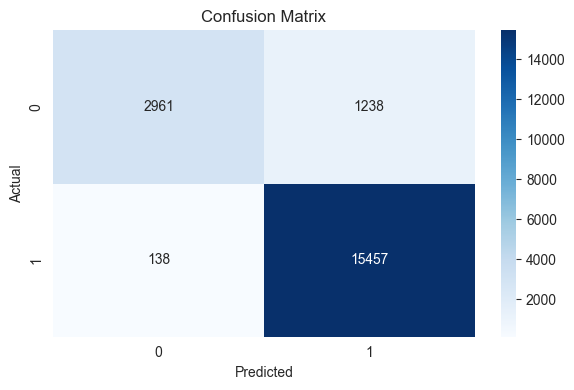

In [19]:
plot_cm(true_labels, predictions)

### Learner

In [20]:
learner0 = download_learner(
    "mlflow-artifacts:/282678262450638424/a4079fa13ff54f0ca0c39520807b2a28/artifacts/learner.zip"
)
learner1 = download_learner(
    "mlflow-artifacts:/282678262450638424/bbbd66c8bf254d339f0c853918ea9428/artifacts/learner.zip"
)

In [21]:
learner0_untrained = PPO(
    env=venvs["state_embeddings"]["airl_0_test"],
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

learner1_untrained = PPO(
    env=venvs["state_embeddings"]["airl_1_test"],
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

In [22]:
eval_policy(learner0_untrained, 50, venvs["state_embeddings"]["airl_0_test"], "before")
eval_policy(learner0, 50, venvs["state_embeddings"]["airl_0_test"], "after")

Mean episode length:  4.14
Reward of the learner policy before training
Mean:  0.3286330532212885
Std:  0.3141468361053959
Mean episode length:  4.14
Reward of the learner policy after training
Mean:  0.39163958916900093
Std:  0.27684934877027645


In [23]:
eval_policy(learner1_untrained, 50, venvs["state_embeddings"]["airl_1_test"], "before")
eval_policy(learner1, 50, venvs["state_embeddings"]["airl_1_test"], "after")

Mean episode length:  23.16
Reward of the learner policy before training
Mean:  0.38956270047413105
Std:  0.4077413964149517
Mean episode length:  23.16
Reward of the learner policy after training
Mean:  0.4240036716476604
Std:  0.4268064842595941


## Semi-Supervised AIRL Evaluation

### Classification

In [24]:
rn0 = download_reward_net(
    "mlflow-artifacts:/720343879195193287/c3122459182745a6931550125ca86cc7/artifacts/reward_net0v2"
)
rn1 = download_reward_net(
    "mlflow-artifacts:/720343879195193287/98b9c7da33354c88821f1eb65b123518/artifacts/reward_net1v2"
)

In [25]:
alpha0, beta0 = grl.calibrate(trajectories["state_embeddings_pre_trained_128"]["airl_val"], rn0)
alpha1, beta1 = grl.calibrate(trajectories["state_embeddings_pre_trained_128"]["airl_val"], rn1)

In [26]:
rewards_cal0_traj_0, rewards_cal1_traj_0 = calcualte_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_pre_trained_128"]["airl_0_test"],
)
rewards_cal0_traj_1, rewards_cal1_traj_1 = calcualte_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_pre_trained_128"]["airl_1_test"],
)

Reward network 0:  0.09410967
Reward network 1:  -0.70131683
Reward network 0:  -0.1630237
Reward network 1:  0.72405946


In [27]:
true_labels, predictions = calc_overall_metrics(
    rewards_cal0_traj_0, rewards_cal1_traj_0, rewards_cal0_traj_1, rewards_cal1_traj_1
)

4199 15595
Accuracy: 0.9785793674850964
Precision: 0.9820169028404397
Recall: 0.9909586405899327
F1 Score: 0.986467509255713


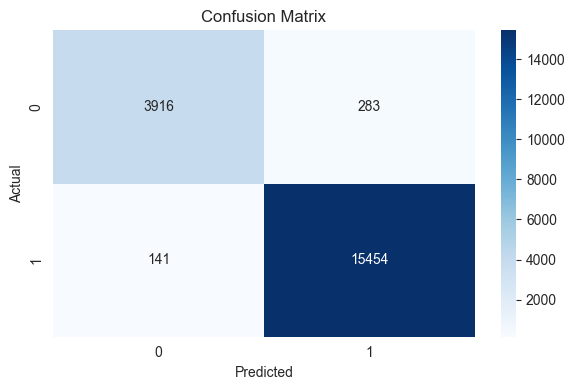

In [28]:
plot_cm(true_labels, predictions)

## Learner

In [29]:
learner0 = download_learner(
    "mlflow-artifacts:/720343879195193287/c3122459182745a6931550125ca86cc7/artifacts/learner0v2.zip"
)
learner1 = download_learner(
    "mlflow-artifacts:/720343879195193287/98b9c7da33354c88821f1eb65b123518/artifacts/learner1v2.zip"
)

In [30]:
learner0_untrained = PPO(
    env=venvs["state_embeddings_pre_trained_128"]["airl_0_test"],
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

learner1_untrained = PPO(
    env=venvs["state_embeddings_pre_trained_128"]["airl_1_test"],
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

In [31]:
eval_policy(
    learner0_untrained, 50, venvs["state_embeddings_pre_trained_128"]["airl_0_test"], "before"
)
eval_policy(learner0, 50, venvs["state_embeddings_pre_trained_128"]["airl_0_test"], "after")

Mean episode length:  4.14
Reward of the learner policy before training
Mean:  0.3286330532212885
Std:  0.3141468361053959
Mean episode length:  4.14
Reward of the learner policy after training
Mean:  0.4555284780578899
Std:  0.2691905050142838


In [32]:
eval_policy(
    learner1_untrained, 50, venvs["state_embeddings_pre_trained_128"]["airl_1_test"], "before"
)
eval_policy(learner1, 50, venvs["state_embeddings_pre_trained_128"]["airl_1_test"], "after")

Mean episode length:  23.16
Reward of the learner policy before training
Mean:  0.38956270047413105
Std:  0.4077413964149517
Mean episode length:  23.16
Reward of the learner policy after training
Mean:  0.4232594856011488
Std:  0.42584910508036355


## Unsupervised AIRL Evaluation

### Classification

In [33]:
rn0 = download_reward_net(
    "mlflow-artifacts:/727687587886726594/cefed3969d824b7bac20b5e9cc5c9c82/artifacts/reward_net"
)
rn1 = download_reward_net(
    "mlflow-artifacts:/727687587886726594/1d2f6162949e4037be776826383853ee/artifacts/reward_net"
)

In [34]:
alpha0, beta0 = grl.calibrate(trajectories["state_embeddings_dgi_128"]["airl_val"], rn0)
alpha1, beta1 = grl.calibrate(trajectories["state_embeddings_dgi_128"]["airl_val"], rn1)

In [35]:
rewards_cal0_traj_0, rewards_cal1_traj_0 = calcualte_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_dgi_128"]["airl_0_test"],
)
rewards_cal0_traj_1, rewards_cal1_traj_1 = calcualte_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_dgi_128"]["airl_1_test"],
)

Reward network 0:  -0.33355594
Reward network 1:  -0.5114584
Reward network 0:  0.7132011
Reward network 1:  0.70656264


In [36]:
true_labels, predictions = calc_overall_metrics(
    rewards_cal0_traj_0, rewards_cal1_traj_0, rewards_cal0_traj_1, rewards_cal1_traj_1
)

4199 15595
Accuracy: 0.5407699302819036
Precision: 0.8291004755640999
Recall: 0.5254248156460404
F1 Score: 0.643221602951566


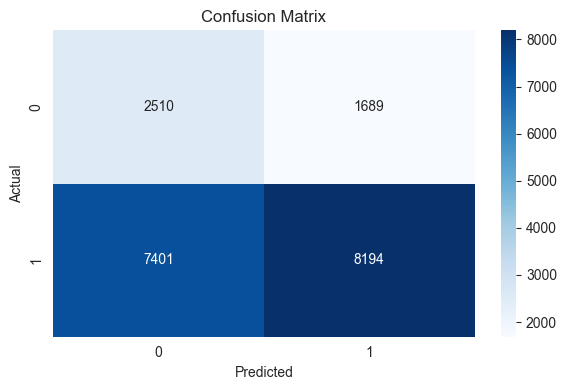

In [37]:
plot_cm(true_labels, predictions)

### Learner

In [38]:
learner0 = download_learner(
    "mlflow-artifacts:/727687587886726594/cefed3969d824b7bac20b5e9cc5c9c82/artifacts/learner.zip"
)
learner1 = download_learner(
    "mlflow-artifacts:/727687587886726594/1d2f6162949e4037be776826383853ee/artifacts/learner.zip"
)

In [39]:
learner0_untrained = PPO(
    env=venvs["state_embeddings_dgi_128"]["airl_0_test"],
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

learner1_untrained = PPO(
    env=venvs["state_embeddings_dgi_128"]["airl_1_test"],
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

In [40]:
eval_policy(learner0_untrained, 50, venvs["state_embeddings_dgi_128"]["airl_0_test"], "before")
eval_policy(learner0, 50, venvs["state_embeddings_dgi_128"]["airl_0_test"], "after")

Mean episode length:  4.14
Reward of the learner policy before training
Mean:  0.3286330532212885
Std:  0.3141468361053959
Mean episode length:  4.14
Reward of the learner policy after training
Mean:  0.3900569561157796
Std:  0.2725262336004807


In [41]:
eval_policy(learner1_untrained, 50, venvs["state_embeddings_dgi_128"]["airl_1_test"], "before")
eval_policy(learner1, 50, venvs["state_embeddings_dgi_128"]["airl_1_test"], "after")

Mean episode length:  23.16
Reward of the learner policy before training
Mean:  0.38956270047413105
Std:  0.4077413964149517
Mean episode length:  23.16
Reward of the learner policy after training
Mean:  0.4240036716476604
Std:  0.4268064842595941
